<a href="https://colab.research.google.com/github/Chandu106/Trafficsign_classification/blob/main/Trafficsign_classification_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd

/content


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("drive/My Drive/archive (5).zip", "r")
zip_ref.extractall()
zip_ref.close()

## **READING THE DATA, AND SPLITTING INTO TRAINING, TESTING, AND VALIDATION DATA IN 80:10:10 RATI0**


In [ ]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
!pip install split-folders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
splitfolders.ratio('/content/train', output="/content/output2", seed=1337, ratio=(0.8, 0.1, 0.1))

Copying files: 39209 files [00:05, 7716.33 files/s]


In [ ]:
train_dir="/content/output2/train"
test_dir="/content/output2/test/"

# **DATA PREPROCESSING**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical') # changed to categorical

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')
     

Found 31367 images belonging to 43 classes.
Found 3922 images belonging to 43 classes.


## **VIEWING THE CLASS NAMES OF THE DATA**

In [ ]:
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)
     

['0' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21'
 '22' '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35'
 '36' '37' '38' '39' '4' '40' '41' '42' '5' '6' '7' '8' '9']


## **ACCURACY AND LOSS CURVES FUNCTION FOR THE MODELS**

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();



# **PREDICTION FUNCTION**

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [30]:

def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {classes[int(pred_class)]}")
  plt.axis(False);

# **LABELLING THE CLASSES**

In [31]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
# Label Overview
classes = [ 'Speed limit (20km/h)',
            'Speed limit (30km/h)', 
            'Speed limit (50km/h)', 
            'Speed limit (60km/h)', 
            'Speed limit (70km/h)', 
            'Speed limit (80km/h)', 
            'End of speed limit (80km/h)', 
            'Speed limit (100km/h)', 
            'Speed limit (120km/h)', 
            'No passing', 
            'No passing veh over 3.5 tons', 
            'Right-of-way at intersection', 
            'Priority road', 
            'Yield', 
            'Stop', 
            'No vehicles', 
            'Veh > 3.5 tons prohibited', 
            'No entry', 
            'General caution', 
            'Dangerous curve left', 
            'Dangerous curve right', 
            'Double curve', 
            'Bumpy road', 
            'Slippery road', 
            'Road narrows on the right', 
            'Road work', 
            'Traffic signals', 
            'Pedestrians', 
            'Children crossing', 
            'Bicycles crossing', 
            'Beware of ice/snow',
            'Wild animals crossing', 
            'End speed + passing limits', 
            'Turn right ahead', 
            'Turn left ahead', 
            'Ahead only', 
            'Go straight or right', 
            'Go straight or left', 
            'Keep right', 
            'Keep left', 
            'Roundabout mandatory', 
            'End of no passing', 
            'End no passing veh > 3.5 tons' ]

     


## **REQUIRED IMPORTS TO BUILD THE MODEL**

In [ ]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D,Dense

# **FIRST MODEL**

In [ ]:
#CREATING MODEL_01


model_01 = Sequential()

#CONVOLUTIONAL LAYER
model_01.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))

#MAXPOOLING LAYER
model_01.add(MaxPool2D(pool_size=(2,2)))

#FLATTEN LAYER TO MATCH THE SIZE OF THE OUTPUT
model_01.add(Flatten())

model_01.add(Dense(256, activation='relu'))

#OUTPUT LAYER
model_01.add(Dense(43, activation='softmax'))

#COMPILE THE MODEL_01

model_01.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

#FITTING THE MODEL_01

history_1 = model_01.fit(train_data, 
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
981/981 [==============================] - 73s 62ms/step - loss: 1.0743 - accuracy: 0.7569 - val_loss: 0.3601 - val_accuracy: 0.8960
Epoch 2/5
981/981 [==============================] - 60s 61ms/step - loss: 0.1663 - accuracy: 0.9534 - val_loss: 0.3065 - val_accuracy: 0.9184
Epoch 3/5
981/981 [==============================] - 74s 75ms/step - loss: 0.1039 - accuracy: 0.9722 - val_loss: 0.3727 - val_accuracy: 0.9166
Epoch 4/5
981/981 [==============================] - 69s 71ms/step - loss: 0.0880 - accuracy: 0.9773 - val_loss: 0.4914 - val_accuracy: 0.8860
Epoch 5/5
981/981 [==============================] - 61s 62ms/step - loss: 0.0531 - accuracy: 0.9864 - val_loss: 0.3957 - val_accuracy: 0.9261


In [ ]:
#EVALUATING OUR MODEL_01 PERFORMANCE ON TEST DATA

model_01.evaluate(test_data)

123/123 [==============================] - 6s 47ms/step - loss: 0.3957 - accuracy: 0.9261


[0.3956666886806488, 0.9260581135749817]

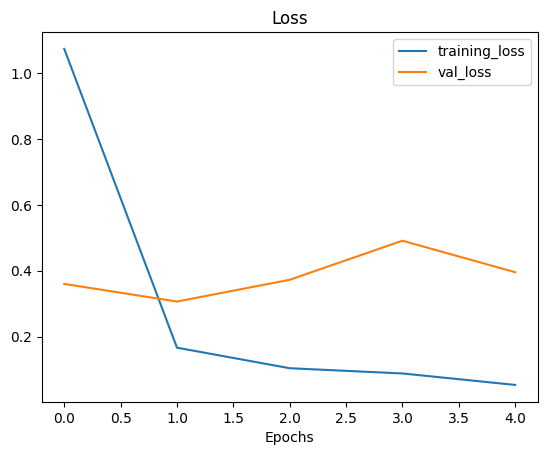

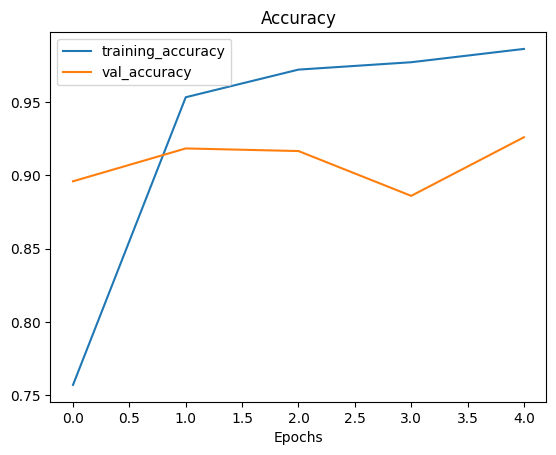

In [ ]:
#MODEL_01 ACCURACY AND LOSS CURVES

plot_loss_curves(history_1)

In [ ]:
#SUMMARY OF MODEL_01

model_01.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 394272)            0         
                                                                 
 dense_12 (Dense)            (None, 256)               100933888 
                                                                 
 dense_13 (Dense)            (None, 43)                11051     
                                                                 
Total params: 100,945,835
Trainable params: 100,945,835
Non-trainable params: 0
________________________________________

# **SECOND MODEL**

In [ ]:
#CREATING MODEL_02


model_02 = Sequential()

#CONVOLUTIONAL LAYER
model_02.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))

#MAXPOOLING LAYER
model_02.add(MaxPool2D(pool_size=(2,2)))

#CONVOLUTIONAL LAYER
model_02.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))

#MAXPOOLING LAYER
model_02.add(MaxPool2D(pool_size=(2,2)))

#FLATTEN LAYER TO MATCH THE SIZE OF THE OUTPUT
model_02.add(Flatten())

model_02.add(Dense(256, activation='relu'))

#OUTPUT LAYER
model_02.add(Dense(43, activation='softmax'))

#COMPILE THE MODEL_02

model_02.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

#FITTING THE MODEL_02

history_02 = model_02.fit(train_data, 
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
981/981 [==============================] - 75s 74ms/step - loss: 0.8881 - accuracy: 0.7520 - val_loss: 0.3221 - val_accuracy: 0.9102
Epoch 2/5
981/981 [==============================] - 59s 60ms/step - loss: 0.1841 - accuracy: 0.9462 - val_loss: 0.2267 - val_accuracy: 0.9365
Epoch 3/5
981/981 [==============================] - 57s 58ms/step - loss: 0.1044 - accuracy: 0.9703 - val_loss: 0.1722 - val_accuracy: 0.9559
Epoch 4/5
981/981 [==============================] - 54s 55ms/step - loss: 0.0801 - accuracy: 0.9784 - val_loss: 0.2181 - val_accuracy: 0.9465
Epoch 5/5
981/981 [==============================] - 56s 57ms/step - loss: 0.0596 - accuracy: 0.9848 - val_loss: 0.3262 - val_accuracy: 0.9281


In [ ]:
#EVALUATING OUR MODEL_02 PERFORMANCE ON TEST DATA

model_02.evaluate(test_data)

123/123 [==============================] - 6s 51ms/step - loss: 0.3262 - accuracy: 0.9281


[0.3262263238430023, 0.9280979037284851]

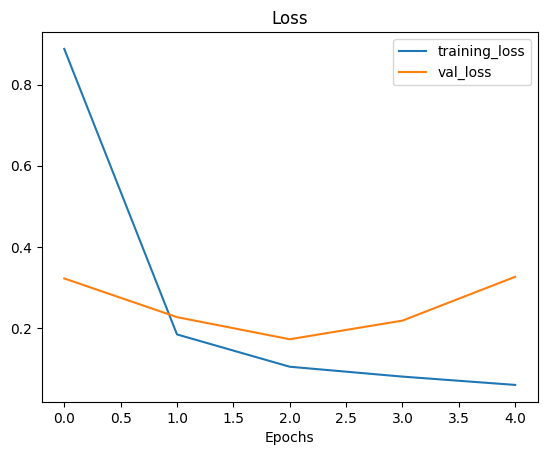

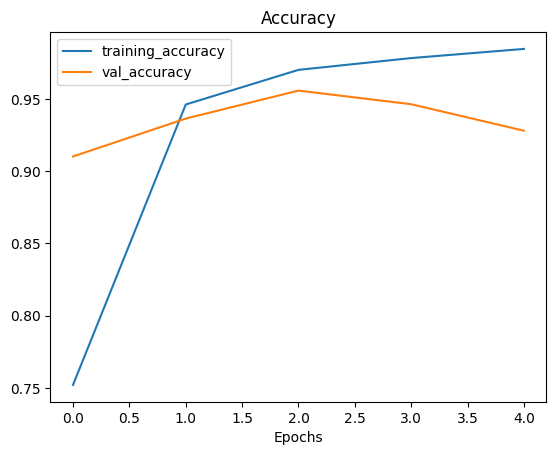

In [ ]:
#MODEL_02 ACCURACY AND LOSS CURVES

plot_loss_curves(history_02)

In [ ]:
#SUMMARY OF MODEL_02

model_02.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 93312)             0         
                                                                 
 dense_14 (Dense)            (None, 256)              

# **THIRD MODEL**

In [ ]:
#CREATING MODEL_03


model_03 = Sequential()

#CONVOLUTIONAL LAYER
model_03.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))
model_03.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))

#MAXPOOLING LAYER
model_03.add(MaxPool2D(pool_size=(2,2)))

#CONVOLUTIONAL LAYER
model_03.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))
model_03.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))

#MAXPOOLING LAYER
model_03.add(MaxPool2D(pool_size=(2,2)))

#FLATTEN LAYER TO MATCH THE SIZE OF THE OUTPUT
model_03.add(Flatten())

model_03.add(Dense(256, activation='relu'))

#OUTPUT LAYER
model_03.add(Dense(43, activation='softmax'))

#COMPILE THE MODEL_03

model_03.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

#FITTING THE MODEL_03

history_03 = model_03.fit(train_data, 
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
981/981 [==============================] - 98s 95ms/step - loss: 0.9086 - accuracy: 0.7345 - val_loss: 0.2896 - val_accuracy: 0.9108
Epoch 2/5
981/981 [==============================] - 87s 89ms/step - loss: 0.1789 - accuracy: 0.9475 - val_loss: 0.1523 - val_accuracy: 0.9539
Epoch 3/5
981/981 [==============================] - 87s 89ms/step - loss: 0.0968 - accuracy: 0.9718 - val_loss: 0.2126 - val_accuracy: 0.9490
Epoch 4/5
981/981 [==============================] - 87s 89ms/step - loss: 0.0765 - accuracy: 0.9766 - val_loss: 0.2146 - val_accuracy: 0.9470
Epoch 5/5
981/981 [==============================] - 87s 89ms/step - loss: 0.0648 - accuracy: 0.9796 - val_loss: 0.1653 - val_accuracy: 0.9640


In [ ]:
#EVALUATING OUR MODEL_03 PERFORMANCE ON TEST DATA

model_03.evaluate(test_data)

123/123 [==============================] - 7s 53ms/step - loss: 0.1653 - accuracy: 0.9640


[0.1652577817440033, 0.9640489816665649]

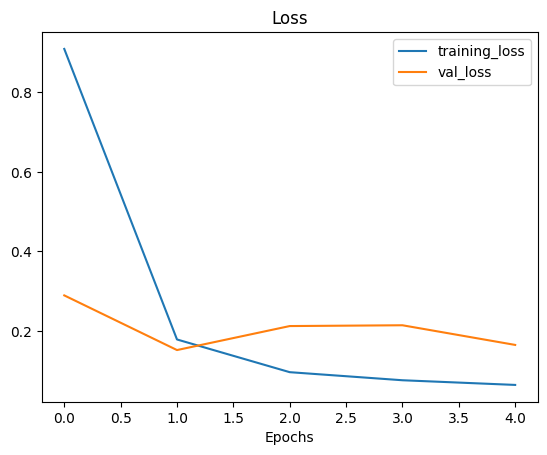

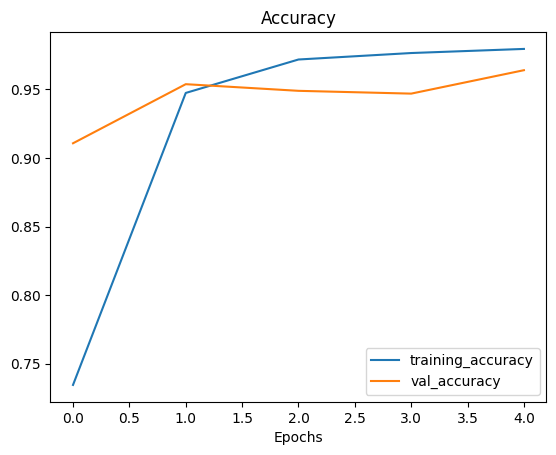

In [ ]:
#MODEL_03 ACCURACY AND LOSS CURVES

plot_loss_curves(history_03)

In [ ]:
#SUMMARY OF MODEL_03

model_03.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 conv2d_12 (Conv2D)          (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 110, 110, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 108, 108, 32)      9248      
                                                                 
 conv2d_14 (Conv2D)          (None, 106, 106, 32)      9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 53, 53, 32)       0         
 g2D)                                                

# **FOURTH MODEL**

In [ ]:
#CREATING MODEL_04


model_04 = Sequential()

#CONVOLUTIONAL LAYER
model_04.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))
model_04.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))
model_04.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))

#MAXPOOLING LAYER
model_04.add(MaxPool2D(pool_size=(2,2)))

#CONVOLUTIONAL LAYER
model_04.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))
model_04.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))
model_04.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))

#MAXPOOLING LAYER
model_04.add(MaxPool2D(pool_size=(2,2)))

#CONVOLUTIONAL LAYER
model_04.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))
model_04.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))
model_04.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))

#MAXPOOLING LAYER
model_04.add(MaxPool2D(pool_size=(2,2)))

#FLATTEN LAYER TO MATCH THE SIZE OF THE OUTPUT
model_04.add(Flatten())

model_04.add(Dense(256, activation='relu'))

#OUTPUT LAYER
model_04.add(Dense(43, activation='softmax'))

#COMPILE THE MODEL_04

model_04.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

#FITTING THE MODEL_04

history_04 = model_04.fit(train_data, 
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
981/981 [==============================] - 143s 138ms/step - loss: 0.6809 - accuracy: 0.8203 - val_loss: 0.1868 - val_accuracy: 0.9516
Epoch 2/5
981/981 [==============================] - 131s 134ms/step - loss: 0.0949 - accuracy: 0.9748 - val_loss: 0.0808 - val_accuracy: 0.9804
Epoch 3/5
981/981 [==============================] - 135s 138ms/step - loss: 0.0683 - accuracy: 0.9806 - val_loss: 0.0893 - val_accuracy: 0.9783
Epoch 4/5
981/981 [==============================] - 130s 133ms/step - loss: 0.0337 - accuracy: 0.9905 - val_loss: 0.0704 - val_accuracy: 0.9847
Epoch 5/5
981/981 [==============================] - 130s 133ms/step - loss: 0.0346 - accuracy: 0.9909 - val_loss: 0.1117 - val_accuracy: 0.9834


In [ ]:
#EVALUATING OUR MODEL_04 PERFORMANCE ON TEST DATA

model_04.evaluate(test_data)

123/123 [==============================] - 6s 51ms/step - loss: 0.1117 - accuracy: 0.9834


[0.11173753440380096, 0.9834268093109131]

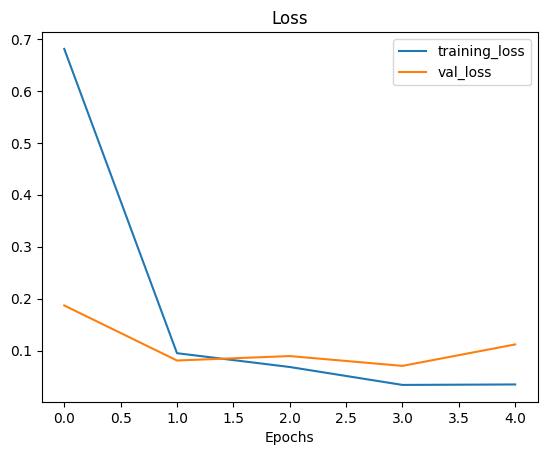

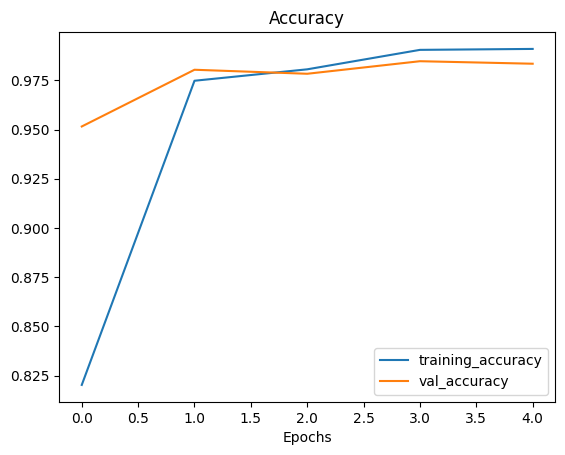

In [ ]:
#MODEL_04 ACCURACY AND LOSS CURVES

plot_loss_curves(history_04)

In [ ]:
#SUMMARY OF MODEL_04

model_04.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 conv2d_16 (Conv2D)          (None, 220, 220, 32)      9248      
                                                                 
 conv2d_17 (Conv2D)          (None, 218, 218, 32)      9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 109, 109, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 107, 107, 32)      9248      
                                                                 
 conv2d_19 (Conv2D)          (None, 105, 105, 32)      9248      
                                                     

In [26]:
#CREATING MODEL_05


model_05 = Sequential()

#CONVOLUTIONAL LAYER
model_05.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))
model_05.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))
model_05.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))
model_05.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))

#MAXPOOLING LAYER
model_05.add(MaxPool2D(pool_size=(2,2)))

#CONVOLUTIONAL LAYER
model_05.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))
model_05.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))
model_05.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))
model_05.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))

#MAXPOOLING LAYER
model_05.add(MaxPool2D(pool_size=(2,2)))

#CONVOLUTIONAL LAYER
model_05.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))
model_05.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))
model_05.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))
model_05.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))

#MAXPOOLING LAYER
model_05.add(MaxPool2D(pool_size=(2,2)))

#CONVOLUTIONAL LAYER
model_05.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))
model_05.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))
model_05.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))
model_05.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))

#MAXPOOLING LAYER
model_05.add(MaxPool2D(pool_size=(2,2)))

#FLATTEN LAYER TO MATCH THE SIZE OF THE OUTPUT
model_05.add(Flatten())

model_05.add(Dense(256, activation='relu'))

#OUTPUT LAYER
model_05.add(Dense(43, activation='softmax'))

#COMPILE THE MODEL_05

model_05.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

#FITTING THE MODEL_05

history_05 = model_05.fit(train_data, 
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
981/981 [==============================] - 182s 180ms/step - loss: 0.8134 - accuracy: 0.7779 - val_loss: 0.1934 - val_accuracy: 0.9495
Epoch 2/5
981/981 [==============================] - 174s 177ms/step - loss: 0.0765 - accuracy: 0.9794 - val_loss: 0.0617 - val_accuracy: 0.9862
Epoch 3/5
981/981 [==============================] - 173s 176ms/step - loss: 0.0485 - accuracy: 0.9863 - val_loss: 0.0694 - val_accuracy: 0.9804
Epoch 4/5
981/981 [==============================] - 173s 176ms/step - loss: 0.0398 - accuracy: 0.9883 - val_loss: 0.0710 - val_accuracy: 0.9799
Epoch 5/5
981/981 [==============================] - 176s 180ms/step - loss: 0.0221 - accuracy: 0.9937 - val_loss: 0.0599 - val_accuracy: 0.9878


In [27]:
#EVALUATING OUR MODEL_05 PERFORMANCE ON TEST DATA

model_05.evaluate(test_data)

123/123 [==============================] - 7s 54ms/step - loss: 0.0599 - accuracy: 0.9878


[0.059854429215192795, 0.9877613186836243]

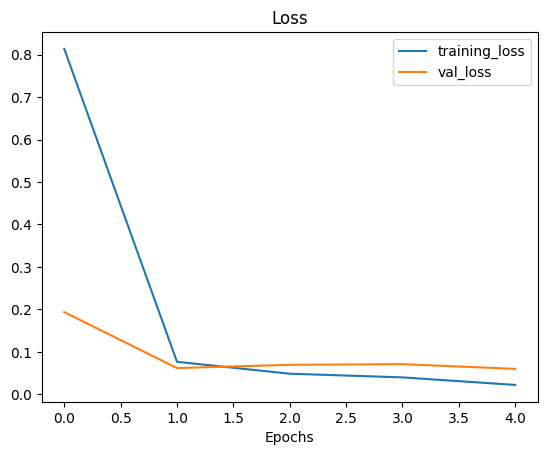

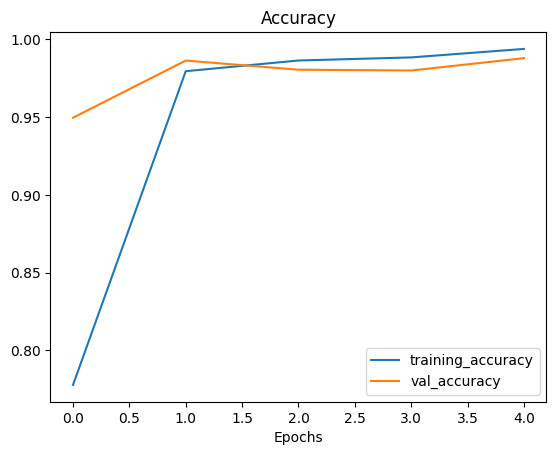

In [28]:
#MODEL_05 ACCURACY AND LOSS CURVES

plot_loss_curves(history_05)

In [29]:
#SUMMARY OF MODEL_05

model_05.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 conv2d_65 (Conv2D)          (None, 220, 220, 32)      9248      
                                                                 
 conv2d_66 (Conv2D)          (None, 218, 218, 32)      9248      
                                                                 
 conv2d_67 (Conv2D)          (None, 216, 216, 32)      9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 108, 108, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 106, 106, 32)      9248      
                                                      

# **PREDICTIONS**

1/1 [==============================] - 1s 1s/step


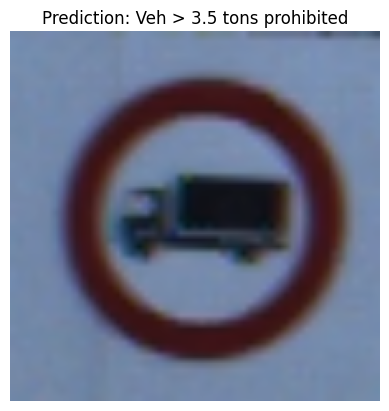

In [32]:
# Make a prediction using efficienet_2_model
pred_and_plot(model=model_05, 
              filename="/content/test/00000.png", 
              class_names=class_names)

1/1 [==============================] - 0s 23ms/step


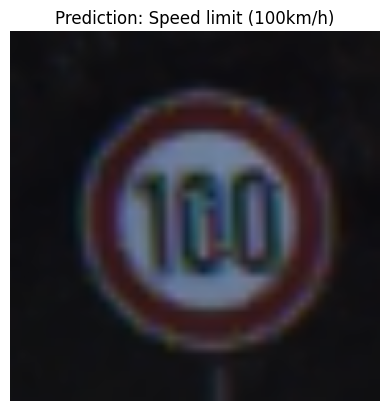

In [33]:
# Make a prediction using efficienet_2_model
pred_and_plot(model=model_05, 
              filename="/content/test/00011.png", 
              class_names=class_names)

1/1 [==============================] - 0s 21ms/step


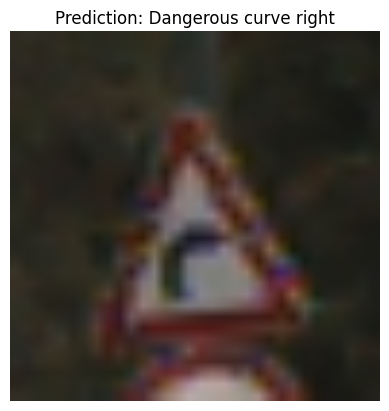

In [35]:
# Make a prediction using efficienet_2_model
pred_and_plot(model=model_05, 
              filename="/content/test/00017.png", 
              class_names=class_names)

1/1 [==============================] - 0s 20ms/step


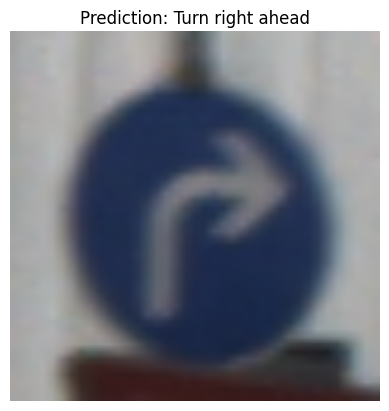

In [38]:
# Make a prediction using efficienet_2_model
pred_and_plot(model=model_05, 
              filename="/content/test/00099.png", 
              class_names=class_names)

1/1 [==============================] - 0s 20ms/step


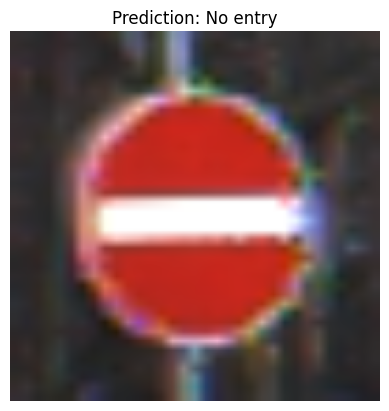

In [41]:
# Make a prediction using efficienet_2_model
pred_and_plot(model=model_05, 
              filename="/content/test/00200.png", 
              class_names=class_names)